<a href="https://colab.research.google.com/github/aksub99/molecular-vae/blob/master/Molecular_VAE_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection

In [0]:
def one_hot_array(i, n):
    return map(int, [ix == i for ix in xrange(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    return "".join(map(lambda x: charset[x], vec)).strip()

def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)


In [0]:
class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
        self.linear_0 = nn.Linear(70, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 33)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

In [0]:
!rm -R 'molecular-vae'
!git clone https://github.com/aksub99/molecular-vae.git
import zipfile
zip_ref = zipfile.ZipFile('molecular-vae/data/processed.zip', 'r')
zip_ref.extractall('molecular-vae/data/')
zip_ref.close()


rm: cannot remove 'molecular-vae': No such file or directory
Cloning into 'molecular-vae'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 162 (delta 19), reused 28 (delta 12), pack-reused 110
Receiving objects: 100% (162/162), 2.91 MiB | 5.14 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [0]:
data_train, data_test, charset = load_dataset('molecular-vae/data/processed.h5')
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, shuffle=True)

data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=250, shuffle=True)

torch.manual_seed(42)

epochs = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
model = MolecularVAE().to(device)
optimizer = optim.Adam(model.parameters())

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()
        output, mean, logvar = model(data)
        
        if batch_idx==0:
              inp = data.cpu().numpy()
              outp = output.cpu().detach().numpy()
              lab = data.cpu().numpy()
              print("Input:")
              print(decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset))
              print("Label:")
              print(decode_smiles_from_indexes(map(from_one_hot_array, lab[0]), charset))
              sampled = outp[0].reshape(1, 120, len(charset)).argmax(axis=2)[0]
              print("Output:")
              print(decode_smiles_from_indexes(sampled, charset))
        
        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss
        optimizer.step()
#         if batch_idx % 100 == 0:
#             print(f'{epoch} / {batch_idx}\t{loss:.4f}')
    print('train', train_loss / len(train_loader.dataset))
    return train_loss / len(train_loader.dataset)
  
def test(epoch):
  with torch.no_grad():
      test_loss = 0.0
      for batch_idx, data in enumerate(test_loader):
          data = data[0].to(device)
          output, mean, logvar = model(data)
          loss = vae_loss(output, data, mean, logvar)
          test_loss += loss
      print('test', test_loss / len(test_loader.dataset))
      return test_loss / len(test_loader.dataset)


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_loss_values = []
test_loss_values = []
for epoch in range(51, epochs + 51):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)
    
    if epoch % 2 == 0:
        torch.save(model.state_dict(), "drive/My Drive/molecular-vae/chembl_50k_{}.pth".format(epoch))

plt.plot(np.array(train_loss_values), 'r')
plt.plot(np.array(test_loss_values), 'b')

Input:
c1cc(cc(c1)Cl)NC(=O)Nc2ccc(cc2)C(=O)N
Label:
c1cc(cc(c1)Cl)NC(=O)Nc2ccc(cc2)C(=O)N
Output:
c1cc(cc(c1)Cl)NC((=))c2ccc(cc2)C(=O)N


/usr/local/lib/python2.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train tensor(50.0701, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(47.2407, device='cuda:0')
Input:
CCOc1ccc(cc1)NC(=O)COc2ccccc2C
Label:
CCOc1ccc(cc1)NC(=O)COc2ccccc2C
Output:
CCOc1ccc(cc1)NC(=O)COc2ccccc2CC
train tensor(42.5512, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(59.9895, device='cuda:0')
Input:
CCOc1ccc(cc1)c2csc3c2c(=O)n(cn3)CC(C)C
Label:
CCOc1ccc(cc1)c2csc3c2c(=O)n(cn3)CC(C)C
Output:
CCOc1ccc(cc1)c2c3c(c(n2=(nnnnn)CCCC)C
train tensor(41.1068, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(47.0606, device='cuda:0')
Input:
c1cc2c(cc1O)O[C@]3(C(=C2)C(=NC(=O)N3)[O-])O
Label:
c1cc2c(cc1O)O[C@]3(C(=C2)C(=NC(=O)N3)[O-])O
Output:
c1cc2c(cc1Cl)CC=C)CC(CC==C===))OOCC(=O)[O-
train tensor(40.6530, device='cuda:0', grad_fn=<DivBackward0>)
test tensor(46.0079, device='cuda:0')
Input:
C[C@@H]1c2c(c3ccccc3[nH]2)CC[NH2+]1
Label:
C[C@@H]1c2c(c3ccccc3[nH]2)CC[NH2+]1
Output:
C[C@@H]1c2ccccccccc3nnH22CCCO[NH++1
train tensor(40.9219, device='cuda:0', grad_fn=<DivBackward

KeyboardInterrupt: ignored

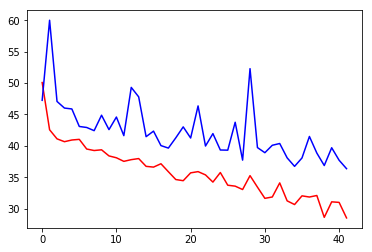

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.array(train_loss_values), 'r')
plt.plot(np.array(test_loss_values), 'b')

In [0]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MolecularVAE().to(device)
model.load_state_dict(torch.load("drive/My Drive/molecular-vae/chembl_50k_50.pth"))

<All keys matched successfully>